In [485]:
import pandas as pd
import regex as re
import numpy as np

import nltk
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob

from sklearn.feature_selection import f_classif, SelectPercentile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline


from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

import joblib
import matplotlib.pyplot as plt



# Task 1 – Data Loading and data preparation

In [486]:
#LOADING THE DATASET
x_train=pd.read_csv("x_train.csv", names=["website_name","text"])
y_train=pd.read_csv("y_train.csv", names=["is_positive_sentiment"])
x_test=pd.read_csv("x_test.csv", names=["website_name","text"])
y_test=pd.read_csv("y_test.csv", names=["is_positive_sentiment"])



#DECONTRACTING THE PHRASES 
def decontracted(phrase): 
    if type(phrase) != str: 
        return(" ")
    # specific
    phrase = re.sub(r"won\t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"did\'nt", "did not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


#SPELL CHECKING FUNCTION

counter=0
def spell_check(text): 
    global counter
    spell = SpellChecker()
    words = spell.split_words(text)
    words=[spell.correction(word) for word in words]
    text = " ".join(words)
    text = text.strip()
    return text

#REMOVING SPECIAL CHARACTERS AND CHANGING TO LOWERCASE

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z\s]'
    text=re.sub(pattern,' ',text)
    return text.lower().strip()


#REMOVING STOPWORDS

def stop_word_remover(text):
    stop_words = stopwords.words('english')    
    stop_words.remove('not')
    stop_words.remove('no')
    stop_words.remove('against')
    word_tokens = word_tokenize(text) 
    filtered_sentence = []
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    filtered_sentence= ' '.join(filtered_sentence)
    return filtered_sentence

#STEMMING THE TEXT
def stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text


#LEMMATIZATION OF THE TEXT
def lemmatizer(text):
    lemma = nltk.wordnet.WordNetLemmatizer()
    text= ' '.join([lemma.lemmatize(word) for word in text.split()])
    return text



x_train['text'] = x_train['text'].apply(decontracted)
x_test['text'] = x_test['text'].apply(decontracted)


x_train['text']=x_train['text'].apply(spell_check)
x_test['text']=x_test['text'].apply(spell_check)


x_train['text']=x_train['text'].apply(remove_special_characters)
x_test['text']=x_test['text'].apply(remove_special_characters)


x_train['text']=x_train['text'].apply(stop_word_remover)
x_test['text']=x_test['text'].apply(stop_word_remover)

x_train['text']=x_train['text'].apply(stemmer)
x_test['text']=x_test['text'].apply(stemmer)


x_train['text']=x_train['text'].apply(lemmatizer)
x_test['text']=x_test['text'].apply(lemmatizer)





# Task 2 – Feature representation

In [487]:


#Count vectorizer for bag of words
cv=CountVectorizer(min_df=1,binary=True,ngram_range=(1,2))
cv_x_train=cv.fit_transform(x_train["text"])
cv_x_test=cv.transform(x_test["text"])
print('BOW_CountVectorizer_train:',cv_x_train.shape)
print('BOW_CountVectorizer_test:',cv_x_test.shape)
vocab=cv.get_feature_names() #toget feature names
print(f'Vocab Size: {len(vocab)}')
#print(vocab)

#Tfidf vectorizer
tv=TfidfVectorizer(min_df=1,smooth_idf=True, use_idf=True, ngram_range=(1,2))
#tv=TfidfVectorizer( max_df=5, use_idf=True, ngram_range=(1,2), stop_words="english") #ANOTHER ALTERNATIVE
#tv = TfidfVectorizer(min_df=5, max_df=0.1, ngram_range=(1,2)) #ANOTHER ALTERNATIVE
tv_x_train=tv.fit_transform(x_train["text"])
tv_x_test=tv.transform(x_test["text"])
selector=SelectPercentile(f_classif, percentile=20)
selector.fit(tv_x_train, y_train.values.ravel())
tv_x_train=selector.transform(tv_x_train).toarray()
tv_x_test=selector.transform(tv_x_test).toarray()
print('Tfidf_train:',tv_x_train.shape)
print('Tfidf_test:',tv_x_test.shape)
print('MINIMUM IDF:',min(tv.idf_))
print('MAXIMUM IDF:',max(tv.idf_))
print('MEAN IDF:',np.mean(tv.idf_))
print('VOCAB:',len(tv.vocabulary_))
print(f"WORD in VOCABULARY: {tv.vocabulary_}")


    




BOW_CountVectorizer_train: (2400, 14573)
BOW_CountVectorizer_test: (600, 14573)
Vocab Size: 14573
Tfidf_train: (2400, 2914)
Tfidf_test: (600, 2914)
MINIMUM IDF: 2.7105960621208482
MAXIMUM IDF: 8.090493415661307
MEAN IDF: 7.944013391454028
VOCAB: 14573
WORD in VOCABULARY: {'oh': 8781, 'forgot': 4805, 'also': 271, 'mention': 7698, 'weird': 13988, 'color': 2279, 'effect': 3561, 'phone': 9359, 'oh forgot': 8783, 'forgot also': 4806, 'also mention': 295, 'mention weird': 7704, 'weird color': 13989, 'color effect': 2283, 'effect phone': 3569, 'one': 8830, 'not': 8463, 'work': 14269, 'either': 3587, 'one not': 8884, 'not work': 8673, 'work either': 14284, 'wast': 13850, 'buck': 1540, 'wast buck': 13851, 'product': 10020, 'useless': 13570, 'sinc': 11620, 'enough': 3722, 'charg': 1988, 'current': 2772, 'cellphon': 1890, 'plan': 9600, 'use': 13521, 'product useless': 10046, 'useless sinc': 13574, 'sinc not': 11630, 'not enough': 8514, 'enough charg': 3727, 'charg current': 1991, 'current charg':

# Task 3 – Classification and Evaluation


========================== PIPELINE WITH MULTINOMIAL NAIVE BAYES ==================================

Fitting 10 folds for each of 24 candidates, totalling 240 fits

Best Model: 0.835000 using {'bow__min_df': 1, 'bow__ngram_range': (1, 2), 'classifier__alpha': 0.1, 'tfidf__use_idf': False}



Mean: 0.790833 Stdev:(0.021230) with: {'bow__min_df': 1, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.1, 'tfidf__use_idf': True}

Mean: 0.812917 Stdev:(0.028226) with: {'bow__min_df': 1, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.1, 'tfidf__use_idf': False}

Mean: 0.774583 Stdev:(0.020704) with: {'bow__min_df': 1, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}

Mean: 0.791250 Stdev:(0.026250) with: {'bow__min_df': 1, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}

Mean: 0.767500 Stdev:(0.019347) with: {'bow__min_df': 1, 'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}

Mean: 0.782917 Stdev

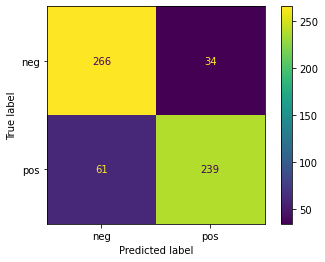



              precision    recall  f1-score   support

           0       0.81      0.89      0.85       300
           1       0.88      0.80      0.83       300

    accuracy                           0.84       600
   macro avg       0.84      0.84      0.84       600
weighted avg       0.84      0.84      0.84       600



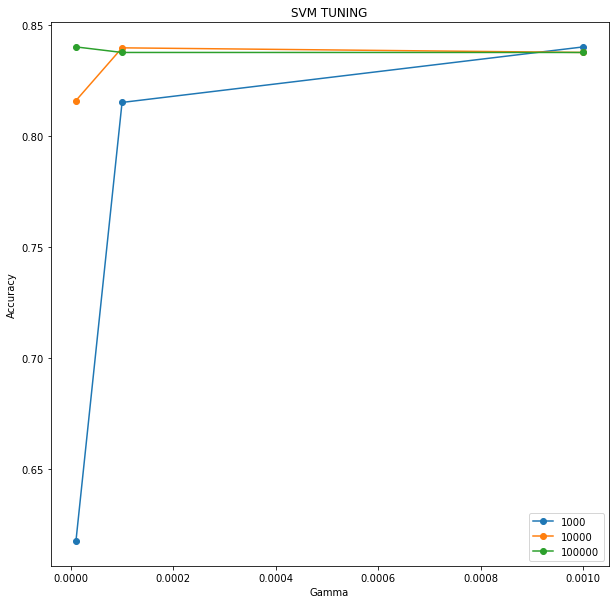

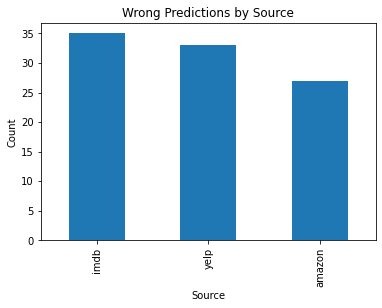

Avg Document Length for Wrong Predictions 78.77894736842106
Avg Document Length for RIGHT Predictions 62.255445544554455


Avg Negation Count for Wrong Predictions 0.30526315789473685
Avg Negation Count for RIGHT Predictions 0.23366336633663368



 Accuracy for Documents WITHOUT NEGATIONS
84.25531914893617
True Positive:225, True Negative:171, False Positive:29, False Negative:45 


 Accuracy for Documents WITH NEGATION
83.84615384615385
True Positive:14, True Negative:95, False Positive:5, False Negative:16 


,website_name,org_text,text,predictions,is_positive_sentiment,text_length,negation_count
104,amazon,Cheap but hey it works.. Was pleasantly suprised given the low cost of this item.,cheap hey work pleasantli supris given low cost item,0,1,81,0
108,amazon,"No shifting, no bubbling, no peeling, not even a scratch, NOTHING!I couldn't be more happier with my new one for the Droid.",no shift no bubbl no peel not even scratch noth could not happier new one droid,0,1,123,5
111,amazon,The delivery was on time.,deliveri time,0,1,25,0
113,amazon,The eargels channel the sound directly into your ear and seem to increase the sound volume and clarity.,eargel channel sound directli ear seem increas sound volum clariti,0,1,103,0
119,amazon,The noise shield is incrediable.,nois shield incredi,0,1,32,0
120,amazon,He was very impressed when going from the original battery to the extended battery.,impress go origin batteri extend batteri,0,1,83,0
136,amazon,"It plays louder than any other speaker of this size; the price is so low that most would think the quality is lacking, however, it's not.",play louder speaker size price low would think qualiti lack howev not,0,1,137,1
141,amazon,A good quality bargain.. I bought this after I bought a cheapy from Big Lots that sounded awful and people on the other end couldn't hear me.,good qualiti bargain bought bought cheapi big lot sound aw peopl end could not hear,0,1,141,1
146,amazon,"I've had no trouble accessing the Internet, downloading ringtones or performing any of the functions.",no troubl access internet download rington perform function,0,1,101,1
147,amazon,It fits so securely that the ear hook does not even need to be used and the sound is better directed through your ear canal.,fit secur ear hook not even need use sound better direct ear canal,0,1,124,1


In [488]:


x_validation, x_text, y_validation, y_text = train_test_split(tv_x_train, 
                                                              y_train.values.ravel(), 
                                                              test_size=.5, 
                                                              random_state=99)


print("\n========================== PIPELINE WITH MULTINOMIAL NAIVE BAYES ==================================\n")

# create pipeline
pipeline1= Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# values for GridSearchCV to iterate over
parameters1 = {'bow__ngram_range': [(1, 1), (1, 2)],
               'bow__min_df': [1, 6],               
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-1,1e-2, 1e-3),
             }

# do 5-fold cross validation for each of the 6 possible combinations of the above params
grid1 = GridSearchCV(pipeline1, cv=10, param_grid=parameters1, verbose=1)
grid1.fit(x_train["text"], y_train.values.ravel())


# summarize results
print("\nBest Model: %f using %s" % (grid1.best_score_, grid1.best_params_))
print('\n')

means1 = grid1.cv_results_['mean_test_score']
stds1 = grid1.cv_results_['std_test_score']
params1 = grid1.cv_results_['params']
for mean, stdev, param in zip(means1, stds1, params1):
    print("\nMean: %f Stdev:(%f) with: %r" % (mean, stdev, param))
    
# save best model to current working directory
joblib.dump(grid, "sentiment_analyser_MNB.pkl")
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("sentiment_analyser_MNB.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(x_test["text"])
print('accuracy score: ',accuracy_score(y_test.values.ravel(), y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test.values.ravel(),y_preds))
print('\n')
print(classification_report(y_test.values.ravel(), y_preds))


print("\n========================== PIPELINE WITH SUPPORT VECTOR MACHINE ==================================\n")

# create pipeline
pipeline2 = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters2 = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__gamma': (0.001,0.0001, 0.00001),
              'classifier__C': (1000, 10000, 100000),
             }

# do 5-fold cross validation for each of the 6 possible combinations of the above params
grid2 = GridSearchCV(pipeline2, cv=5, param_grid=parameters2, verbose=1)
grid2.fit(x_train["text"], y_train.values.ravel())


# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means2 = grid2.cv_results_['mean_test_score']
stds2 = grid2.cv_results_['std_test_score']
params2 = grid2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
    print("\nMean: %f Stdev:(%f) with: %r" % (mean, stdev, param))


# save best model to current working directory
joblib.dump(grid2, "sentiment_analyser_SVM.pkl")
# load from file and predict using the best configs found in the CV step
model_SVM = joblib.load("sentiment_analyser_SVM.pkl" )

# get predictions from best model above
y_preds = model_SVM.predict(x_test["text"])
print('accuracy score: ',accuracy_score(y_test.values.ravel(), y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test.values.ravel(),y_preds))
fig=ConfusionMatrixDisplay(confusion_matrix(y_test.values.ravel(),
                                        y_preds), 
                       display_labels=['neg','pos']).plot()
plt.show(fig)
print('\n')
print(classification_report(y_test.values.ravel(), y_preds))


A=[]
C=[]
G=[]

for mean, param in zip(means2, params2):
    if param["bow__ngram_range"]==(1,2) and param["tfidf__use_idf"]==True:
        #print("\nMean: %f with: %r" % (mean,param))
        A.append(mean)
        G.append(param["classifier__gamma"])
        C.append(param["classifier__C"])
df=pd.DataFrame({"A":A, "G":G, "C":C})
plt.figure(figsize=(10,10))
df.set_index('G', inplace=True)
df.groupby("C")["A"].plot(title="SVM TUNING",legend=True, marker="o", xlabel="Gamma", ylabel="Accuracy")
plt.show()


pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

def calc_length(text):
    return len(text)

def find_negations(text):
    n=0
    neg_words=['no','not']
    text=text.split()
    for word in text:
        if word in neg_words:
               n=n+1
    return n

x_test["predictions"]=y_preds

x_original=pd.read_csv("x_test.csv", names=["website_name","org_text"])

final_df=pd.concat([x_original,x_test["text"],x_test["predictions"], y_test], axis=1)

final_df["text_length"]=final_df["org_text"].apply(calc_length)

final_df["negation_count"]=final_df["text"].apply(find_negations)


wrong_predictions=final_df[final_df["predictions"]!=final_df["is_positive_sentiment"]]



plt1=wrong_predictions["website_name"].value_counts().plot(kind="bar", 
                                            title="Wrong Predictions by Source",
                                            xlabel="Source",
                                            ylabel="Count")

plt.show(plt1)



print(f'Avg Document Length for Wrong Predictions {wrong_predictions["text_length"].mean()}')

right_predictions=final_df[final_df["predictions"]==final_df["is_positive_sentiment"]]

print(f'Avg Document Length for RIGHT Predictions {right_predictions["text_length"].mean()}')


print(f'\n\nAvg Negation Count for Wrong Predictions {wrong_predictions["negation_count"].mean()}')
print(f'Avg Negation Count for RIGHT Predictions {right_predictions["negation_count"].mean()}')

print("\n\n\n Accuracy for Documents WITHOUT NEGATIONS")


no_negtn_df=final_df[final_df["negation_count"]==0]

df=no_negtn_df[(no_negtn_df["predictions"]==1) & (no_negtn_df["is_positive_sentiment"]==1)]
TP=df.shape[0]

df=no_negtn_df[(no_negtn_df["predictions"]==0) & (no_negtn_df["is_positive_sentiment"]==0)]
TN=df.shape[0]

df=no_negtn_df[(no_negtn_df["predictions"]==1) & (no_negtn_df["is_positive_sentiment"]==0)]
FP=df.shape[0]

df=no_negtn_df[(no_negtn_df["predictions"]==0) & (no_negtn_df["is_positive_sentiment"]==1)]
FN=df.shape[0]

print(((TP+TN)/(TP+TN+FP+FN))*100)

print(f"True Positive:{TP}, True Negative:{TN}, False Positive:{FP}, False Negative:{FN} ")

print('\n\n Accuracy for Documents WITH NEGATION')

negtn_df=final_df[final_df["negation_count"]>0]

df=negtn_df[(negtn_df["predictions"]==1) & (negtn_df["is_positive_sentiment"]==1)]
TP=df.shape[0]

df=negtn_df[(negtn_df["predictions"]==0) & (negtn_df["is_positive_sentiment"]==0)]
TN=df.shape[0]

df=negtn_df[(negtn_df["predictions"]==1) & (negtn_df["is_positive_sentiment"]==0)]
FP=df.shape[0]

df=negtn_df[(negtn_df["predictions"]==0) & (negtn_df["is_positive_sentiment"]==1)]
FN=df.shape[0]

print(((TP+TN)/(TP+TN+FP+FN))*100)


print(f"True Positive:{TP}, True Negative:{TN}, False Positive:{FP}, False Negative:{FN} ")

final_df[(final_df["predictions"]!=final_df["is_positive_sentiment"]) & (final_df["is_positive_sentiment"] == 1)]

#final_df[(final_df["predictions"]!=final_df["is_positive_sentiment"]) & (final_df["is_positive_sentiment"] == 0)].apply(print)


